In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle
from tqdm.notebook import tqdm
from Eearly_stop import *
from sklearn.metrics import roc_auc_score, accuracy_score
import sys
import pandas as pd
import argparse
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import math
from torch.utils.data import Dataset, DataLoader
from src_py.cpmix_utils import preprocess_data
from src_py.rhorho import RhoRhoEvent
from src_py.a1a1 import A1A1Event
from src_py.a1rho import A1RhoEvent
from src_py.data_utils import read_np, EventDatasets
from src_py.process_background import convert_bkgd_raw
import train_rhorho, train_a1rho, train_a1a1
from src_py.metrics_utils import calculate_deltas_unsigned, calculate_deltas_signed

In [2]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print('Using {} device'.format(device))

Using cpu device


In [3]:
decaymodes = ['rhorho', 'a1rho', 'a1a1']
types = {"nn_rhorho": train_rhorho.start,"nn_a1rho": train_a1rho.start,"nn_a1a1": train_a1a1.start}
parser = argparse.ArgumentParser(description='Train classifier')

parser.add_argument("--num_classes", dest="NUM_CLASSES", type=int, default=11)
parser.add_argument("-l", "--layers", dest="LAYERS", type=int, help = "number of NN layers", default=6)
parser.add_argument("-s", "--size", dest="SIZE", type=int, help="NN size", default=100)
parser.add_argument("-lambda", "--lambda", type=float, dest="LAMBDA", help="value of lambda parameter", default=0.0)
parser.add_argument("-m", "--method", dest="METHOD", choices=["A", "B", "C"], default="A")
parser.add_argument("-o", "--optimizer", dest="OPT", 
    choices=["GradientDescentOptimizer", "AdadeltaOptimizer", "AdagradOptimizer",
         "ProximalAdagradOptimizer", "AdamOptimizer", "FtrlOptimizer",
         "ProximalGradientDescentOptimizer", "RMSPropOptimizer"], default="AdamOptimizer")
parser.add_argument("-d", "--dropout", dest="DROPOUT", type=float, default=0.0)
parser.add_argument("-e", "--epochs", dest="EPOCHS", type=int, default=3)
# parser.add_argument("-f", "--features", dest="FEAT", help="Features", default="Variant-All")
# #         choices= ["Variant-All", "Variant-1.0", "Variant-1.1", "Variant-2.0", "Variant-2.1",
# #                   "Variant-2.2", "Variant-3.0", "Variant-3.1", "Variant-4.0", "Variant-4.1"])

########### Change this to according dir to download data #######################
parser.add_argument("-i", "--input", dest="IN", default='/home/anderson/higgs_data/rhorho')

parser.add_argument("--miniset", dest="MINISET", type=lambda s: s.lower() in ['true', 't', 'yes', '1'], default=False)
parser.add_argument("--z_noise_fraction", dest="Z_NOISE_FRACTION", type=float, default=0.0)

parser.add_argument("--delt_classes", dest="DELT_CLASSES", type=int, default=0,
                    help='Maximal distance between predicted and valid class for event being considered as correctly classified')

parser.add_argument("--unweighted", dest="UNWEIGHTED", type=lambda s: s.lower() in ['true', 't', 'yes', '1'], default=False)
parser.add_argument("--reuse_weights", dest="REUSE_WEIGHTS", type=bool, default=False)
parser.add_argument("--restrict_most_probable_angle", dest="RESTRICT_MOST_PROBABLE_ANGLE", type=bool, default=False)
parser.add_argument("--force_download", dest="FORCE_DOWNLOAD", type=bool, default=False)
parser.add_argument("--normalize_weights", dest="NORMALIZE_WEIGHTS", type=bool, default=False)


parser.add_argument("--beta",  type=float, dest="BETA", help="value of beta parameter for polynomial smearing", default=0.0)
parser.add_argument("--pol_b", type=float, dest="pol_b", help="value of b parameter for polynomial smearing", default=0.0)
parser.add_argument("--pol_c", type=float, dest="pol_c", help="value of c parameter for polynomial smearing", default=0.0)

parser.add_argument("--w1", dest="W1")
parser.add_argument("--w2", dest="W2")
parser.add_argument("--f", dest="FEAT", default="Variant-All")
parser.add_argument("--plot_features", dest="PLOT_FEATURES", choices=["NO", "FILTER", "NO-FILTER"], default="NO")
parser.add_argument("--training_method", dest="TRAINING_METHOD", choices=["soft_weights", "soft_c012s",  "soft_argmaxs", "regr_c012s", "regr_weights", "regr_argmaxs"], default="soft_weights")
parser.add_argument("--hits_c012s", dest="HITS_C012s", choices=["hits_c0s", "hits_c1s",  "hits_c2s"], default="hits_c0s")

######Change this to according type (rhorho, a1rho, a1a1)#######################
parser.add_argument("-t", "--type", dest="TYPE", choices=types.keys(), default='nn_rhorho')

parser.add_argument("-r", "--reprocess", dest="REPRO", type=bool, default=True)

parser.add_argument("-bkgd", "--bkgdpath", dest="BKGDPATH", default='/home/anderson/Ztt_raw/pythia.Z_115_135.%s.1M.*.outTUPLE_labFrame')
parser.add_argument("--train_bkgd", dest="TRAINBKGD", default=False)
parser.add_argument("--z_fraction", dest="Z_FRACTION", type=float, default=0.0)

args, unknown = parser.parse_known_args()

### Preprocessing signal samples from all the decaymodes

In [4]:
from ROOT import Math

def Cart4DToPtEtaPhiE(data):
    print("Converting p4 to HEP coordinates")
    df_data = pd.DataFrame(data)
    
    particle_name = ['n', 'pi-', 'pi0_1', 'an', 'pi+', 'pi0_2']
    df_data.columns = pd.MultiIndex.from_arrays([sum([[x]*4 for x in particle_name],[]), ['p_x', 'p_y', 'p_z', 'E']*6])

    particle_PtEtaPhiE={}
    for particle in particle_name:
        total_res = {}
        for index, row in tqdm(df_data[particle].iterrows(),total=df_data[particle].shape[0]):
            res = Math.PxPyPzEVector(*row.values.tolist())
            total_res[index] = (res.pt(), res.eta(), res.phi(), res.e())
        particle_PtEtaPhiE[particle] = total_res

    PtEtaPhiE = [pd.DataFrame(particle_PtEtaPhiE[particle].values(), columns=[particle+x for x in ['_pt','_eta','_phi','_E']]) for particle in particle_name]
    return PtEtaPhiE

Welcome to JupyROOT 6.24/06


In [5]:
events={'nn_rhorho':'RhoRhoEvent', 'nn_a1rho':'A1RhoEvent', 'nn_a1a1':'A1A1Event'}
if args.REPRO:
    for decaymode in tqdm(decaymodes):
        points = []
        args.IN = '/home/anderson/higgs_data/'+decaymode
        args.TYPE = 'nn_'+decaymode
        data, weights, argmaxs, perm, c012s, hits_argmaxs, hits_c012s = preprocess_data(args)
        event = RhoRhoEvent(data, args)
        # convert p4 to HEP coordinates
        raw_df = Cart4DToPtEtaPhiE(event.cols)
        visible_part_id = [1, 2, 4, 5]
        raw_df_concat = pd.concat([raw_df[i] for i in visible_part_id], axis=1)
        event.cols = np.append(raw_df_concat.to_numpy(),np.zeros([len(event.cols),1]),1)
        points.append(EventDatasets(event, weights, argmaxs, perm, c012s=c012s, hits_argmaxs=hits_argmaxs, hits_c012s=hits_c012s, miniset=args.MINISET, unweighted=args.UNWEIGHTED))
        pickle.dump(points,open(args.IN+'/events_PtEtaPhiE_visible_only_11.pk','wb'))
        break

  0%|          | 0/3 [00:00<?, ?it/s]

Loading data
Read 1000000 events
Converting p4 to HEP coordinates


  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

(1000000, 16)
SCALE!!


### Loading signal samples

In [6]:
points=pickle.load(open(args.IN+'/events_PtEtaPhiE_visible_only_11.pk','rb'))

### Training NN

In [7]:
batch_size=512

In [8]:
class MyDataset(Dataset):
    def __init__(self, rhorho_data_mc,rhorho_data_true,rhorho_labels_mc,rhorho_labels_true):
        self.rhorho_data_mc = torch.from_numpy(rhorho_data_mc).float().to(device)
        self.rhorho_data_true = torch.from_numpy(rhorho_data_true).float().to(device)
        
        self.rhorho_labels_mc =torch.from_numpy(rhorho_labels_mc).float().to(device)
        self.rhorho_labels_true =torch.from_numpy(rhorho_labels_true).float().to(device)
    def __getitem__(self, index):
        return self.rhorho_data_mc[index],self.rhorho_data_true[index],self.rhorho_labels_mc[index],self.rhorho_labels_true[index]
    def __len__(self):
        return min(len(self.rhorho_labels_mc),len(self.rhorho_labels_true))

In [9]:
class NeuralNetwork(nn.Module):
    def __init__(self, num_features, num_classes, num_layers=1, size=100, lr=1e-3, drop_prob=0, inplace=False, 
                 tloss="regr_weights", activation='linear', input_noise=0.0, optimizer="AdamOptimizer"):
        super(NeuralNetwork, self).__init__()
        self.linear1 = nn.Linear(num_features,size,bias=False)
        layers = []
        for i in range(num_layers):
            layers.extend([nn.Linear(size,size,bias=False),
                           nn.BatchNorm1d(size),
                           nn.ReLU(),
                           nn.Dropout(drop_prob, inplace)
                          ])
        self.linear_relu_stack = nn.Sequential(*layers)
        self.linear2 = nn.Linear(size,num_classes,bias=False)
        self.linear3 = nn.Linear(size,2,bias=False)
    def forward(self, x):
        x = self.linear1(x)
        x = self.linear_relu_stack(x)
        out = self.linear2(x)
        return out

In [10]:
particle_idx=0

mc_train_idx=np.random.choice(np.arange(points[particle_idx].train.x.shape[0]),int(points[particle_idx].train.x.shape[0]*0.5),replace=False)
true_train_idx=list(set(np.arange(points[particle_idx].train.x.shape[0]))-set(mc_train_idx))

mc_valid_idx=np.random.choice(np.arange(points[particle_idx].valid.x.shape[0]),int(points[particle_idx].valid.x.shape[0]*0.5),replace=False)
true_valid_idx=list(set(np.arange(points[particle_idx].valid.x.shape[0]))-set(mc_train_idx))

mc_test_idx=np.random.choice(np.arange(points[particle_idx].test.x.shape[0]),int(points[particle_idx].test.x.shape[0]*0.5),replace=False)
true_test_idx=list(set(np.arange(points[particle_idx].test.x.shape[0]))-set(mc_train_idx))

In [11]:
uncertainty=0.0

train_datasets = MyDataset(points[particle_idx].train.x[mc_train_idx], points[particle_idx].train.x[true_train_idx]+uncertainty*np.random.normal(0,1,size=points[particle_idx].train.x[true_train_idx].shape),
                          points[particle_idx].train.weights[mc_train_idx],points[particle_idx].train.weights[true_train_idx])
train_loader = DataLoader(dataset = train_datasets,batch_size = batch_size,shuffle = True)


valid_datasets = MyDataset(points[particle_idx].valid.x[mc_valid_idx], points[particle_idx].valid.x[true_valid_idx]+uncertainty*np.random.normal(0,1,size=points[particle_idx].valid.x[true_valid_idx].shape),
                          points[particle_idx].valid.weights[mc_valid_idx],points[particle_idx].valid.weights[true_valid_idx])
valid_loader = DataLoader(dataset = valid_datasets,batch_size = batch_size,shuffle = True)


test_datasets = MyDataset(points[particle_idx].test.x[mc_test_idx], points[particle_idx].test.x[true_test_idx]+uncertainty*np.random.normal(0,1,size=points[particle_idx].test.x[true_test_idx].shape),
                          points[particle_idx].test.weights[mc_test_idx],points[particle_idx].test.weights[true_test_idx])
test_loader = DataLoader(dataset = test_datasets,batch_size = batch_size,shuffle = True)

In [12]:
model = NeuralNetwork(num_features=points[particle_idx].train.x.shape[1], num_classes=args.NUM_CLASSES,num_layers=args.LAYERS,drop_prob=0).to(device)
opt_g = torch.optim.Adam(model.parameters(),lr=1e-3)
criterion = nn.CrossEntropyLoss()
early_stopping = EarlyStopping(patience=20, verbose=True,path='model/pTEtaPhiE_visible_only.pt')

In [13]:
epoch=200
training_loss=[]
validation_loss=[]

for i in range(epoch):
    # training step
    model.train()
    train_loss,train_acc,train_numbers = 0,0,0
    for batch_idx, (rhorho_s,rhorho_t,label_s,label_t) in enumerate(train_loader):
        opt_g.zero_grad()
        rhorho_s = rhorho_s[label_s.sum(axis=1)!=0]
        label_s = label_s[label_s.sum(axis=1)!=0]
        outputs = model(rhorho_s)
        if isinstance(criterion,nn.CrossEntropyLoss):
            loss=criterion(outputs,torch.argmax(label_s,axis=1))
        else:
            loss=criterion(outputs,label_s)
        loss.backward()
        opt_g.step()
        _, predictions = torch.max(outputs, 1)
        train_loss += loss.item()*len(rhorho_s)
        train_acc += (predictions==torch.argmax(label_s,axis=1)).sum().item()
        train_numbers += len(rhorho_s)
        print('\r training loss: %.3f \t acc: %.3f \t' %(train_loss/train_numbers,train_acc/train_numbers),end='')
    print()
    training_loss.append(train_loss/train_numbers)
    
    # validation step
    model.eval()
    valid_loss,valid_acc,valid_numbers = 0,0,0
    with torch.no_grad():
        for batch_idx, (rhorho_s,rhorho_t,label_s,label_t) in enumerate(valid_loader):
            rhorho_s = rhorho_s[label_s.sum(axis=1)!=0]
            label_s = label_s[label_s.sum(axis=1)!=0]
            outputs = model(rhorho_s)
            if isinstance(criterion,nn.CrossEntropyLoss):
                loss=criterion(outputs,torch.argmax(label_s,axis=1))
            else:
                loss=criterion(outputs,label_s)
            _, predictions = torch.max(outputs, 1)
            valid_loss += loss.item()*len(rhorho_s)
            valid_acc += (predictions==torch.argmax(label_s,axis=1)).sum().item()
            valid_numbers += len(rhorho_s)
            print('\r validation loss: %.3f \t acc: %.3f \t' %(valid_loss/valid_numbers,valid_acc/valid_numbers),end='')
    print()
    validation_loss.append(valid_loss/valid_numbers)

    # early stopping
    early_stopping(-valid_acc/valid_numbers,model)
    if early_stopping.early_stop:
        print("Early stopping")
        break
    print()

 training loss: 2.094 	 acc: 0.230 	
 validation loss: 2.028 	 acc: 0.255 	
Validation loss decreased (inf --> -0.254917).  Saving model ...

 training loss: 2.020 	 acc: 0.257 	
 validation loss: 2.016 	 acc: 0.259 	
Validation loss decreased (-0.254917 --> -0.259357).  Saving model ...

 training loss: 2.010 	 acc: 0.261 	
 validation loss: 2.009 	 acc: 0.264 	
Validation loss decreased (-0.259357 --> -0.263696).  Saving model ...

 training loss: 2.003 	 acc: 0.264 	
 validation loss: 2.008 	 acc: 0.263 	
EarlyStopping counter: 1 out of 20

 training loss: 1.999 	 acc: 0.265 	
 validation loss: 2.001 	 acc: 0.266 	
Validation loss decreased (-0.263696 --> -0.265745).  Saving model ...

 training loss: 1.996 	 acc: 0.266 	
 validation loss: 2.001 	 acc: 0.265 	
EarlyStopping counter: 1 out of 20

 training loss: 1.993 	 acc: 0.267 	
 validation loss: 1.993 	 acc: 0.267 	
Validation loss decreased (-0.265745 --> -0.266850).  Saving model ...

 training loss: 1.991 	 acc: 0.268 	
 vali

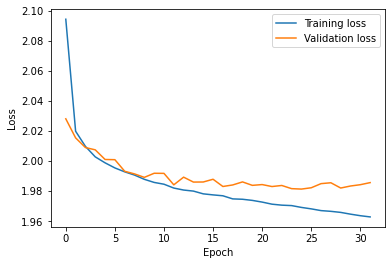

In [14]:
plt.plot(training_loss, label="Training loss")
plt.plot(validation_loss, label="Validation loss")

plt.legend()

plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

### Testing NN

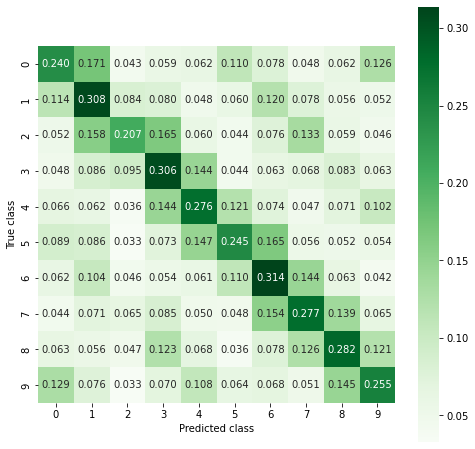

In [19]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

model.load_state_dict(torch.load('model/pTEtaPhiE_visible_only.pt'))

model.eval()
with torch.no_grad():
    outputs,labels=[],[]
    for batch_idx, (rhorho_s,rhorho_t,label_s,label_t) in enumerate(valid_loader):
        outputs.append(model(rhorho_s).detach().cpu())
        labels.append(label_s.detach().cpu())
outputs=torch.softmax(torch.cat(outputs),axis=1).numpy()
labels=np.concatenate(labels)

LABELS = range(0,args.NUM_CLASSES-1)
conf_matrix = confusion_matrix(np.argmax(labels,axis=1), np.argmax(outputs,axis=1), normalize="true")
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, square = True, cmap="Greens", fmt='.3f')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()